# CS440 Term Project

Data Source: https://finance.yahoo.com/

### Project Description

In today’s modern world, staying updated on technological advancements has become a necessity for businesses to satisfy their customers, achieve desired business goals, and most importantly outsmart the competition. In recent years, the financial sector has seen a rapid acceleration in the use of Artificial Intelligence (AI) and Machine Learning (ML) due to improved software and hardware. This has led to better outcomes for both consumers and businesses. Hedge funds were the primary users of AI and ML in financial services, but in the last few years, the spread of ML applications was seen in banks, insurance firms, and other financial institutions, to name a few. But the most steadfast and steep increase has been seen in the stock markets. AI and ML are shaping the future of stock markets. Using different techniques and deep learning algorithms, it analyzes millions of data points, predicts forecast markets with better accuracy, and as a result, there is a higher probability for higher profits and returns. 

The prediction of the volatile and unpredictable stock market has been challenging in recent years, since there are so many factors to take into consideration, such as economic factors, interest rate changes, and fiscal policy. While humans remain a large part of the trading, the stock market has become more efficient and accurate because of the recent developments in AI and ML. These techniques have made it easier for beginners to invest in the stock market. AI and ML also use pattern recognition and help gather unbiased information which leads to better predictions for traders and investors. 

The goal of this project is to train stock market datasets using different AI and ML algorithms such as Neural Networks, k-Nearest Neighbors (kNN), and Logistic Regression and try to find the best predictions. We aim to get results using the above three algorithms and see which ones best predict the outcomes of the stock market. The goal is to see which algorithm more accurately and efficiently predicts the stock market. The benefits of using these algorithms to predict outcomes are that it extracts noise and leaves out as much signal as possible and time complexity is less, hence results are available faster. 

### Data Description

This dataset includes the historical daily prices and volume information for US stocks and ETFs trading on NASDAQ, NYSE, and NYSE MKT. We do not believe using stock open and close prices and volume will be enough to predict accurately. We will need to use other ‘technical’ data like RSI which represents the relative strength of a stock and other indicators along with the open and close price.

In [1]:
# Imports
import numpy as np
import pandas as pd
import math
import pandas_ta as pta
from matplotlib import pyplot as plt
%matplotlib inline
import talib as ta
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU, LSTM
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from pandas.plotting import register_matplotlib_converters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### S&P 500

In [2]:
# Read SpyData CSV
spyData = pd.read_csv('Data/SPY.csv', sep = ",")

#Compute RSI
"""
rsi = pta.rsi(np.array(spyData.Close), length = 14)
"""

#Compute EMA**

#Compute STOCH %K & %D

stochKD = pta.stoch(low = spyData.Low, high = spyData.High, close = spyData.Close, k=14, d=3, smooth_k = 9)
stochKD = stochKD.iloc[10: , :]
spyData = spyData.iloc[23: , :]

spyData.reset_index(inplace = True)
spyData = spyData.drop("index", 1)

spyData["%K"] = np.array(stochKD.STOCHk_14_3_9)
spyData["%D"] = np.array(stochKD.STOCHd_14_3_9)

#Adding the slope the stoch lines (1 pos, 0 neg)
""""
stochSlope = []
for i in range(spyData.shape[0]):
    if(spyData["%K"][i] > spyData["%D"][i]):
        stochSlope.append(1)
    if(spyData["%K"][i] < spyData["%D"][i]):
        stochSlope.append(0)

spyData["Stoch Slope"] = np.array(stochSlope)
"""

#Compute Price 1 | 0 price in 10d (1 = up & 0 = down)

tenDay = []
for i in range(spyData.shape[0]-10):
    if(spyData.Close[i] - spyData.Close[i+10] < 0):
        tenDay.append(1)
    else:
        tenDay.append(0)
spyData = spyData.iloc[:-10]
spyData["Ten Day Gain"] = np.array(tenDay)

In [3]:
#Remove Columns

spyData = spyData.drop(["Adj Close", "Volume","Date", "%K", "%D"], 1)
#spyData = spyData.drop("Stoch Slope", 1)

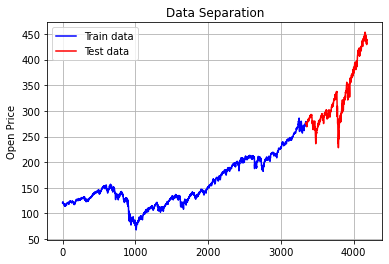

In [4]:
n = spyData.shape[0]
splitRow = int(n * 0.80)
spyData2 = spyData.to_numpy()

#Splits
x_train = spyData2[:splitRow, :-1]
y_train = spyData2[:splitRow, -1]
x_test = spyData2[splitRow:, :-1]
y_test = spyData2[splitRow:, -1]

#Chart Plot
xPlot = range(0, n)
plt.figure()
plt.title('Data Separation')
plt.grid(True)
plt.ylabel('Open Price')
plt.plot(xPlot[:splitRow], x_train[:,0], 'blue', label='Train data')
plt.plot(xPlot[splitRow:], x_test[:,0], 'red', label='Test data')
plt.legend()
plt.show()
plt.close()

In [5]:
norm = MinMaxScaler()
x_train = norm.fit_transform(x_train)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

nFeatures = x_train.shape[1]
epochs = 10
batchSize = 1000
nOutput = 1
kernelSize = 1

In [6]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = kernelSize, padding = 'same', activation = 'relu', input_shape = (nFeatures, 1)))
model.add(Conv1D(filters = 64, kernel_size = kernelSize, padding = 'same'))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling1D(pool_size = (1)))
model.add(Conv1D(filters = 128, kernel_size = kernelSize, padding = 'same'))
model.add(LeakyReLU(alpha = 0.01))
model.add(Flatten())
model.add(Dense(256,))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.8))
model.add(Dense(nOutput, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

fitReturn = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size = batchSize, verbose = 1)

Epoch 1/10
4/4 [==============================] - 1s 71ms/step - loss: 0.6885 - accuracy: 0.5503 - val_loss: 42.3800 - val_accuracy: 0.6930
Epoch 2/10
4/4 [==============================] - 0s 22ms/step - loss: 0.6740 - accuracy: 0.6098 - val_loss: 82.6664 - val_accuracy: 0.6930
Epoch 3/10
4/4 [==============================] - 0s 27ms/step - loss: 0.6729 - accuracy: 0.6098 - val_loss: 81.6072 - val_accuracy: 0.6930
Epoch 4/10
4/4 [==============================] - 0s 29ms/step - loss: 0.6740 - accuracy: 0.6098 - val_loss: 60.5455 - val_accuracy: 0.6930
Epoch 5/10
4/4 [==============================] - 0s 40ms/step - loss: 0.6703 - accuracy: 0.6098 - val_loss: 53.2826 - val_accuracy: 0.6930
Epoch 6/10
4/4 [==============================] - 0s 25ms/step - loss: 0.6723 - accuracy: 0.6098 - val_loss: 49.2535 - val_accuracy: 0.6930
Epoch 7/10
4/4 [==============================] - 0s 20ms/step - loss: 0.6728 - accuracy: 0.6098 - val_loss: 45.9457 - val_accuracy: 0.6930
Epoch 8/10
4/4 [====

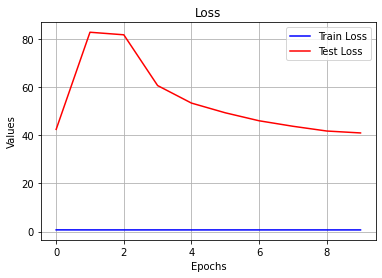

In [7]:
plt.title('Loss')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(fitReturn.history['loss'], 'blue', label='Train Loss')
plt.plot(fitReturn.history['val_loss'], 'red', label='Test Loss')
plt.legend()
plt.show()
plt.close()

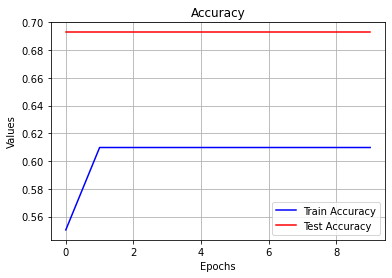

In [8]:
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(fitReturn.history['accuracy'], 'blue', label='Train Accuracy')
plt.plot(fitReturn.history['val_accuracy'], 'red', label='Test Accuracy')
plt.legend()
plt.show()
plt.close()

In [9]:
#print(x_test)
predictY = model.predict(x_test, verbose=0)
#print(predictY)
predictY = predictY[:, 0]

# Basic Counting
testY0 = (y_test == 0).sum()
testY1 = (y_test == 1).sum()
print("Test Set - Sell signal : "+str(testY0))
print("Test Set - Buy signal  : "+str(testY1))
#print("="*40)
predictY0 = (predictY == 0).sum()
predictY1 = (predictY == 1).sum()
print("Predicted - Sell signal : "+str(predictY0))
print("Predicted - Buy signal  : "+str(predictY1))

Test Set - Sell signal : 257
Test Set - Buy signal  : 580
Predicted - Sell signal : 0
Predicted - Buy signal  : 837


In [10]:

#print(y_test)
#print(predictY)
accuracy = accuracy_score(y_test, predictY)
precision = precision_score(y_test, predictY)
print('Accuracy: '+str(accuracy))
print('Precision: '+str(precision))

Accuracy: 0.6929510155316607
Precision: 0.6929510155316607


### TESLA

#### Data Preprocessing

In [11]:
# Read In Data
tsla = pd.read_csv('Data/TSLA.csv', sep = ",")
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
1,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
3,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
4,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500


#### Convolutional Neural Network

In [12]:
tsla1 = tsla.dropna()
tsla1['Open10'] = tsla1['Open'].shift(periods = -14)
tsla1 = tsla1.dropna()
tsla1['label'] = np.where(tsla1['Open'] < tsla1['Open10'], 1, 0)
tsla1a = tsla1.drop(labels = ['Date', 'Adj Close', 'Open10'], axis = 1)
tsla1a

,Open,High,Low,Close,Volume,label
0,5.158000,6.084000,4.660000,4.766000,85935500,0
1,5.000000,5.184000,4.054000,4.392000,41094000,0
2,4.600000,4.620000,3.742000,3.840000,25699000,0
3,4.000000,4.000000,3.166000,3.222000,34334500,1
4,3.280000,3.326000,2.996000,3.160000,34608500,1
...,...,...,...,...,...,...
2832,779.799988,793.500000,770.679993,781.309998,20942900,1
2833,781.000000,789.130005,775.000000,775.479980,17956000,1
2834,778.400024,780.780029,763.590027,775.219971,17031400,1
2835,796.500000,806.969971,776.119995,781.530029,30483300,1


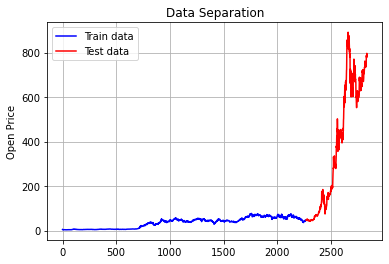

In [13]:
x, _ = tsla1a.shape
splitRow = int(x * 0.80)
tsla1b = tsla1a.to_numpy()

# Training data and testing data
trainX = tsla1b[:splitRow, :-1]
trainY = tsla1b[:splitRow, -1]
testX = tsla1b[splitRow:, :-1]
testY = tsla1b[splitRow:, -1] 

xPlot = range(0, x)
plt.figure()
plt.title('Data Separation')
plt.grid(True)
plt.ylabel('Open Price')
plt.plot(xPlot[:splitRow], trainX[:,0], 'blue', label='Train data')
plt.plot(xPlot[splitRow:], testX[:,0], 'red', label='Test data')
plt.legend()
plt.show()
plt.close()

In [14]:
norm = MinMaxScaler()
trainX = norm.fit_transform(trainX)

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

nFeatures = trainX.shape[1]
epochs = 20
batchSize = 1000
nOutput = 1
kernelSize = 1


In [15]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = kernelSize, padding = 'same', activation = 'relu', input_shape = (nFeatures, 1)))
model.add(Conv1D(filters = 64, kernel_size = kernelSize, padding = 'same'))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling1D(pool_size = (1)))
model.add(Conv1D(filters = 128, kernel_size = kernelSize, padding = 'same'))
model.add(LeakyReLU(alpha = 0.01))
model.add(Flatten())
model.add(Dense(256,))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.8))
model.add(Dense(nOutput, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

fitReturn = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = epochs, batch_size = batchSize, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 32)             64        
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 64)             2112      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 5, 64)             0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 128)            8320      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 5, 128)            0         
                                                      

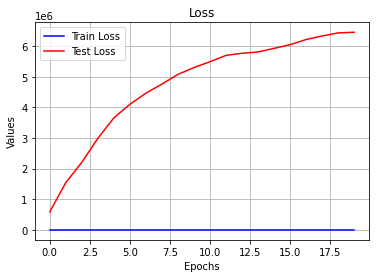

In [16]:
plt.title('Loss')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(fitReturn.history['loss'], 'blue', label='Train Loss')
plt.plot(fitReturn.history['val_loss'], 'red', label='Test Loss')
plt.legend()
plt.show()
plt.close()

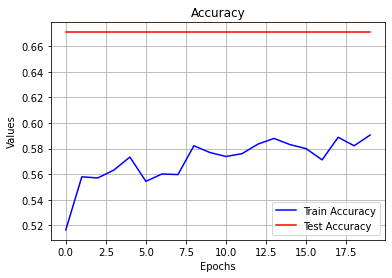

In [17]:
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(fitReturn.history['accuracy'], 'blue', label='Train Accuracy')
plt.plot(fitReturn.history['val_accuracy'], 'red', label='Test Accuracy')
plt.legend()
plt.show()
plt.close()

In [18]:
predictY = model.predict(testX)
predictY = predictY[:, 0]

# Basic Counting
testY0 = (testY == 0).sum()
testY1 = (testY == 1).sum()
print("Test Set - Sell signal : "+str(testY0))
print("Test Set - Buy signal  : "+str(testY1))
print("="*40)
predictY0 = (predictY == 0).sum()
predictY1 = (predictY == 1).sum()
print("Predicted - Sell signal : "+str(predictY0))
print("Predicted - Buy signal  : "+str(predictY1))

Test Set - Sell signal : 187
Test Set - Buy signal  : 381
Predicted - Sell signal : 0
Predicted - Buy signal  : 568


In [19]:
accuracy = accuracy_score(testY, predictY)
precision = precision_score(testY, predictY)
print('Accuracy: '+str(accuracy))
print('Precision: '+str(precision))

Accuracy: 0.670774647887324
Precision: 0.670774647887324


#### Logistic Regression

In [20]:
tsla2 = tsla.dropna()
tsla2

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
1,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
3,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
4,2010-07-07,3.280000,3.326000,2.996000,3.160000,3.160000,34608500
...,...,...,...,...,...,...,...
2846,2021-10-19,877.530029,877.950012,862.510010,864.270020,864.270020,17381100
2847,2021-10-20,865.349976,869.489990,857.380005,865.799988,865.799988,14032100
2848,2021-10-21,856.000000,900.000000,855.500000,894.000000,894.000000,31481500
2849,2021-10-22,895.500000,910.000000,890.960022,909.679993,909.679993,22836800


In [21]:
tsla2['S_10'] = tsla2['Close'].rolling(window = 14).mean()
tsla2['Corr'] = tsla2['Close'].rolling(window = 14).corr(tsla2['S_10'])
tsla2['RSI'] = ta.RSI(np.array(tsla2['Close']), timeperiod = 14)
# The difference between the open price of yesterday and today
tsla2['Open-Close'] = tsla2['Open'] - tsla2['Close'].shift(1)
# The difference close price of yesterday and the open price of today
tsla2['Open-Open'] = tsla2['Open'] - tsla2['Open'].shift(1)
tsla2 = tsla2.dropna()
tsla2 = tsla2.drop(['Date', 'Adj Close', 'Volume'], axis = 1)
X = tsla2.iloc[:,:9]
tsla2
X

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open
26,4.020000,4.032000,3.904000,3.918000,4.135571,0.002894,39.801858,-0.070000,-0.288000
27,3.980000,3.996000,3.890000,3.920000,4.125571,-0.140996,39.855375,0.062000,-0.040000
28,3.930000,3.930000,3.764000,3.806000,4.108571,-0.286179,37.792968,0.010000,-0.050000
29,3.738000,3.776000,3.570000,3.580000,4.064286,-0.185847,34.033064,-0.068000,-0.192000
30,3.560000,3.580000,3.478000,3.520000,4.011571,0.101116,33.091795,-0.020000,-0.178000
...,...,...,...,...,...,...,...,...,...
2846,877.530029,877.950012,862.510010,864.270020,805.652858,0.954407,77.905531,7.420044,25.740051
2847,865.349976,869.489990,857.380005,865.799988,812.104287,0.961354,78.155131,1.079956,-12.180053
2848,856.000000,900.000000,855.500000,894.000000,820.588575,0.970934,82.156379,-9.799988,-9.349976
2849,895.500000,910.000000,890.960022,909.679993,829.742144,0.978317,83.920029,1.500000,39.500000


In [22]:
y = np.where(tsla2['Close'].shift(-1) > tsla2['Close'],1,-1)

In [23]:
split = int(0.7 * len(tsla2))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [24]:
model = LogisticRegression()
model = model.fit (X_train, y_train)
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,0,1
0,Open,[0.3037471457723646]
1,High,[-0.22613461367017546]
2,Low,[-0.2091599129080941]
3,Close,[0.13802902699981864]
4,S_10,[-0.007673439761046159]
5,Corr,[0.054339045538926704]
6,RSI,[-0.004489472786957012]
7,Open-Close,[-0.05601794381946111]
8,Open-Open,[0.018270039184202436]


In [25]:
probability = model.predict_proba(X_test)
print(probability)

[[5.51710446e-01 4.48289554e-01]
 [5.48116120e-01 4.51883880e-01]
 [5.85572142e-01 4.14427858e-01]
 ...
 [9.93096128e-01 6.90387244e-03]
 [5.75143213e-01 4.24856787e-01]
 [9.99989296e-01 1.07043775e-05]]


In [26]:
probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)

[[5.51710446e-01 4.48289554e-01]
 [5.48116120e-01 4.51883880e-01]
 [5.85572142e-01 4.14427858e-01]
 ...
 [9.93096128e-01 6.90387244e-03]
 [5.75143213e-01 4.24856787e-01]
 [9.99989296e-01 1.07043775e-05]]


In [27]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))
print(model.score(X_test,y_test))

[[214 183]
 [237 214]]
              precision    recall  f1-score   support

          -1       0.47      0.54      0.50       397
           1       0.54      0.47      0.50       451

    accuracy                           0.50       848
   macro avg       0.51      0.51      0.50       848
weighted avg       0.51      0.50      0.50       848

0.5047169811320755


In [28]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

[0.51236749 0.50883392 0.49116608 0.51236749 0.5229682  0.5177305
 0.4751773  0.5212766  0.46099291 0.5212766 ]
0.5044157080921233


/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### k-Nearest Neigbors

In [29]:
tsla3 = tsla.dropna()
tsla3

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
1,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
3,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
4,2010-07-07,3.280000,3.326000,2.996000,3.160000,3.160000,34608500
...,...,...,...,...,...,...,...
2846,2021-10-19,877.530029,877.950012,862.510010,864.270020,864.270020,17381100
2847,2021-10-20,865.349976,869.489990,857.380005,865.799988,865.799988,14032100
2848,2021-10-21,856.000000,900.000000,855.500000,894.000000,894.000000,31481500
2849,2021-10-22,895.500000,910.000000,890.960022,909.679993,909.679993,22836800


In [30]:
tsla3 = tsla3[['Open', 'High', 'Close', 'Low']]
tsla3['Open-Close'] = tsla3.Open - tsla3.Close
tsla3['High-Low'] = tsla3.High = tsla3.Low
tsla3 = tsla3.dropna()
X_knn = tsla3[['Open-Close', 'High-Low']]
Y_knn = np.where(tsla3['Close'].shift(-1) > tsla3['Close'], 1, -1)
split3 = int(0.7 * len(tsla3))

X_train_knn = tsla3[:split3]
Y_train_knn = Y_knn[:split3]
X_test_knn = tsla3[split3:]
Y_test_knn = Y_knn[split3:]

<ipython-input-30-cd4297f9873e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla3['Open-Close'] = tsla3.Open - tsla3.Close
<ipython-input-30-cd4297f9873e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla3['High-Low'] = tsla3.High = tsla3.Low
/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [31]:
train = []
test = []

for i in range(1, 151, 5):
    knn = KNeighborsClassifier(n_neighbors = i * 10)
    knn.fit(X_train_knn, Y_train_knn)
    train.append(accuracy_score(Y_train_knn, knn.predict(X_train_knn)))
    test.append(accuracy_score(Y_test_knn, knn.predict(X_test_knn)))

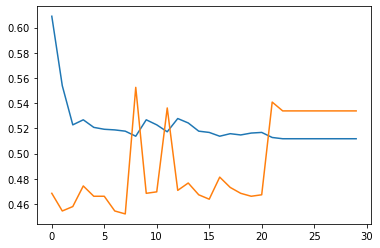

In [32]:
plt.plot(train)
plt.plot(test)

In [33]:
print("Average of the training set =", round(sum(train)/len(train), 2))
print("Average of the testing set =", round(sum(test)/len(test), 2))

Average of the training set = 0.52
Average of the testing set = 0.49


### LSTM

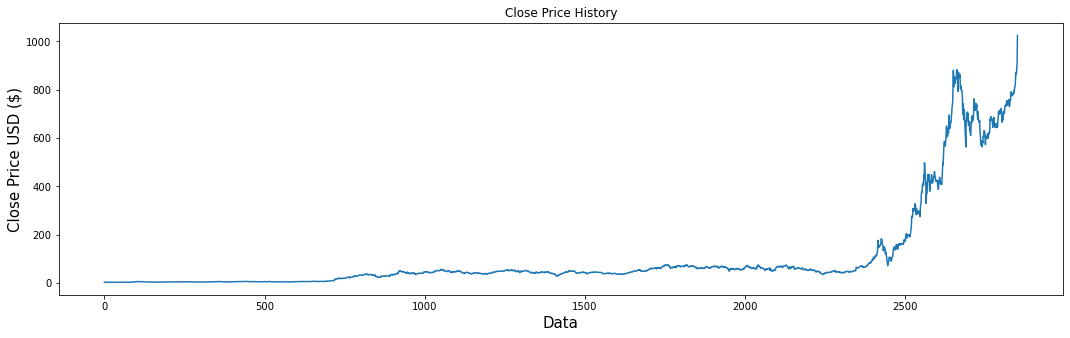

In [34]:
plt.figure(figsize=(18,5))
plt.title('Close Price History')
plt.plot(tsla['Close'])
plt.xlabel('Data', fontsize=15 )
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.show()

In [35]:
#Create a dataframe with only the 'Create Column
data= tsla.filter(['Close'])
#convert the dataframe to a numpy array
dataset= data.values
#get the number of rows to train the model on
training_data_len= math.ceil(len(dataset)* 0.85)

In [36]:
#Scale the all of the data to be values between 0 and 1 
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)

In [37]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(180,len(train_data)):
    x_train.append(train_data[i-180:i,0])
    y_train.append(train_data[i,0])


In [38]:
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2244, 180, 1)

In [39]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [40]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2244/2244 [==============================] - 171s 75ms/step - loss: 4.2487e-05


In [41]:
#Test data set
test_data = scaled_data[training_data_len - 180: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(180,len(test_data)):
    x_test.append(test_data[i-180:i,0])

In [42]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
#Undo scaling
rmse = math.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
print(rmse)
print(mae)

152.82808694397693
119.85182464737746


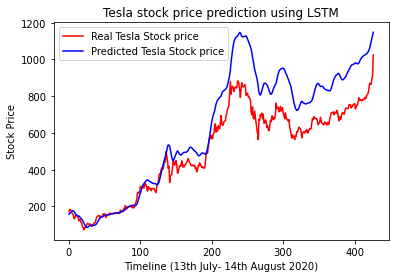

In [43]:
# Visualising the results
plt.plot(y_test,color='red',label='Real Tesla Stock price')
plt.plot(predictions,color='blue',label='Predicted Tesla Stock price')
plt.title('Tesla stock price prediction using LSTM')
plt.xlabel('Timeline (13th July- 14th August 2020)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()